<a href="https://colab.research.google.com/github/mugsiemx/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization_take1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
# import the repository for the csv file
! git clone https://github.com/mugsiemx/deep-learning-challenge

In [2]:
# Import our dependencies
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler

# read the CSV file from the Resources folder into a dask DataFrame
## change the data types to strings and integers
%time df = dd.read_csv('/content/deep-learning-challenge/Resources/charity_data.csv', low_memory=False,\
                       dtype={'APPLICATION_TYPE': 'string','AFFILIATION': 'string','CLASSIFICATION': 'string',\
                              'USE_CASE': 'string','ORGANIZATION': 'string','STATUS': 'int','INCOME_AMT': 'string',\
                              'SPECIAL_CONSIDERATIONS': 'string'}\
                       )
# review the DataFrame
df.dtypes, df.shape

CPU times: user 14.4 ms, sys: 4.84 ms, total: 19.3 ms
Wall time: 41.9 ms


(EIN                        int64
 NAME                      object
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object,
 (Delayed('int-117b2761-9665-4042-9b8c-e4894c0eba4b'), 12))

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
df = df.drop(['EIN','NAME'], axis=1)
df.info(), df.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, APPLICATION_TYPE to IS_SUCCESSFUL
dtypes: int64(3), string(7)

(None,
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object)

In [4]:
# create DataFrame with compute
application_df = df.compute()
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


# Analyze individual columns for optimization opportunities

In [5]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

* APPLICATION_TYPE

In [6]:
app_counts = application_df['APPLICATION_TYPE'].value_counts()
app_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: Int64

In [7]:
application_df.groupby(['IS_SUCCESSFUL','APPLICATION_TYPE'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  APPLICATION_TYPE
0              T10                    64
               T12                     3
               T13                     5
               T19                   864
               T2                      7
               T25                     1
               T3                  12649
               T4                   1071
               T5                    273
               T6                    316
               T7                    315
               T8                    426
               T9                     44
1              T10                   464
               T12                    24
               T13                    61
               T14                     3
               T15                     2
               T17                     1
               T19                   201
               T2                      9
               T25                     2
               T29                     2
               T3        

* AFFILIATION

In [8]:
afl_counts = application_df['AFFILIATION'].value_counts()
afl_counts

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: Int64

In [9]:
application_df.groupby(['IS_SUCCESSFUL','AFFILIATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  AFFILIATION     
0              CompanySponsored    10493
               Family/Parent          28
               Independent          5499
               National               13
               Regional                5
1              CompanySponsored     5212
               Family/Parent          36
               Independent         12981
               National               20
               Other                   4
               Regional                8
Name: IS_SUCCESSFUL, dtype: int64

* CLASSIFICATION

In [10]:
cls_counts = application_df['CLASSIFICATION'].value_counts()
cls_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C5200        1
C2600        1
C4200        1
C2190        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: Int64

In [11]:
application_df.groupby(['IS_SUCCESSFUL','CLASSIFICATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  CLASSIFICATION
0              C0                   1
               C1000             7566
               C1200             2599
               C1230                6
               C1236                1
                                 ... 
1              C7200               28
               C7210                7
               C8000               14
               C8200                1
               C8210                1
Name: IS_SUCCESSFUL, Length: 108, dtype: int64

* USE_CASE

In [12]:
use_counts = application_df['USE_CASE'].value_counts()
use_counts

Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: Int64

In [13]:
application_df.groupby(['IS_SUCCESSFUL','USE_CASE'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  USE_CASE     
0              CommunityServ      250
               Heathcare           83
               Preservation     12978
               ProductDev        2727
1              CommunityServ      134
               Heathcare           63
               Other                3
               Preservation     15117
               ProductDev        2944
Name: IS_SUCCESSFUL, dtype: int64

* ORGANIZATION

In [14]:
org_counts = application_df['ORGANIZATION'].value_counts()
org_counts

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: Int64

In [15]:
application_df.groupby(['IS_SUCCESSFUL','ORGANIZATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ORGANIZATION
0              Association      6202
               Co-operative      119
               Corporation        10
               Trust            9707
1              Association      4053
               Co-operative      367
               Corporation        33
               Trust           13808
Name: IS_SUCCESSFUL, dtype: int64

* STATUS

In [16]:
sts_counts = application_df['STATUS'].value_counts()
sts_counts

1    34294
0        5
Name: STATUS, dtype: int64

In [17]:
application_df.groupby(['IS_SUCCESSFUL','STATUS'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  STATUS
0              0             2
               1         16036
1              0             3
               1         18258
Name: IS_SUCCESSFUL, dtype: int64

* INCOME_AMT

In [18]:
inc_counts = application_df['INCOME_AMT'].value_counts()
inc_counts

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: Int64

In [19]:
application_df.groupby(['IS_SUCCESSFUL','INCOME_AMT'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  INCOME_AMT   
0              0                11811
               1-9999             175
               10000-24999        175
               100000-499999     1422
               10M-50M            143
               1M-5M              510
               25000-99999       1612
               50M+                92
               5M-10M              98
1              0                12577
               1-9999             553
               10000-24999        368
               100000-499999     1952
               10M-50M             97
               1M-5M              445
               25000-99999       2135
               50M+                47
               5M-10M              87
Name: IS_SUCCESSFUL, dtype: int64

* SPECIAL_CONSIDERATIONS

In [20]:
spc_counts = application_df['SPECIAL_CONSIDERATIONS'].value_counts()
spc_counts

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: Int64

In [21]:
application_df.groupby(['IS_SUCCESSFUL','SPECIAL_CONSIDERATIONS'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  SPECIAL_CONSIDERATIONS
0              N                         16028
               Y                            10
1              N                         18244
               Y                            17
Name: IS_SUCCESSFUL, dtype: int64

* ASK_AMT

In [22]:
ask_counts = application_df['ASK_AMT'].value_counts()
ask_counts

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [23]:
application_df.groupby(['IS_SUCCESSFUL','ASK_AMT'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ASK_AMT   
0              5000          12095
               5006              2
               5040              1
               5044              1
               5050              1
                             ...  
1              1281905997        1
               1736232349        1
               2310256039        1
               3391919220        1
               8597806340        1
Name: IS_SUCCESSFUL, Length: 8823, dtype: int64


# Create bins for features with a low number of "bucket" counts

---



In [24]:
# APPLICATION_TYPE - Revise default bins
application_types_to_replace = app_counts[app_counts < 1000].index.values
    
# # Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
Other     2266
T4        1542
T6        1216
T5        1173
T19       1065
Name: APPLICATION_TYPE, dtype: Int64

In [25]:
# AFFILIATION - Revise default bins
affiliations_to_replace = afl_counts[afl_counts < 15000].index.values

# Replace in dataframe
for afl in affiliations_to_replace:
    application_df['AFFILIATION'] = application_df['AFFILIATION'].replace(afl,"Other")
    
# Check to make sure binning was successful
application_df['AFFILIATION'].value_counts()

Independent         18480
CompanySponsored    15705
Other                 114
Name: AFFILIATION, dtype: Int64

In [26]:
# CLASSIFICATION - Revise default bins
classification_to_replace = cls_counts[cls_counts < 1000].index.values

# Replace in dataframe
for cls in classification_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: Int64

In [27]:
# USE_CASE - Revise default bins
use_case_to_replace = use_counts[use_counts < 2000].index.values

# Replace in dataframe
for use in use_case_to_replace:
    application_df['USE_CASE'] = application_df['USE_CASE'].replace(use,"Other")
    
# Check to make sure binning was successful
application_df['USE_CASE'].value_counts()

Preservation    28095
ProductDev       5671
Other             533
Name: USE_CASE, dtype: Int64

In [28]:
# ASK_AMT - Revise default bins
application_df['ask_amt_bin'] = pd.qcut(application_df['ASK_AMT'], duplicates='drop', q=10)
application_df.groupby(['IS_SUCCESSFUL','ask_amt_bin'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ask_amt_bin             
0              (4999.999, 30898.8]         12899
               (30898.8, 196546.2]          1462
               (196546.2, 8597806340.0]     1677
1              (4999.999, 30898.8]         14540
               (30898.8, 196546.2]          1968
               (196546.2, 8597806340.0]     1753
Name: IS_SUCCESSFUL, dtype: int64

In [29]:
application_df['ask_amt_bin'].value_counts()

(4999.999, 30898.8]         27439
(30898.8, 196546.2]          3430
(196546.2, 8597806340.0]     3430
Name: ask_amt_bin, dtype: int64

# Drop unproductive columns, convert categorical variables into zeroes/ones, confirm df

In [30]:
application_df = application_df.drop(['ORGANIZATION', 'STATUS', 'SPECIAL_CONSIDERATIONS', 'ASK_AMT'], axis=1)
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, APPLICATION_TYPE to IS_SUCCESSFUL
dtypes: int64(3), string(7)

In [31]:
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,INCOME_AMT,IS_SUCCESSFUL,ask_amt_bin
0,Other,Independent,C1000,ProductDev,0,1,"(4999.999, 30898.8]"
1,T3,Independent,C2000,Preservation,1-9999,1,"(30898.8, 196546.2]"
2,T5,CompanySponsored,C3000,ProductDev,0,0,"(4999.999, 30898.8]"
3,T3,CompanySponsored,C2000,Preservation,10000-24999,1,"(4999.999, 30898.8]"
4,T3,Independent,C1000,Other,100000-499999,1,"(30898.8, 196546.2]"
...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,0,0,"(4999.999, 30898.8]"
34295,T4,CompanySponsored,C3000,ProductDev,0,0,"(4999.999, 30898.8]"
34296,T3,CompanySponsored,C2000,Preservation,0,0,"(4999.999, 30898.8]"
34297,T5,Independent,C3000,ProductDev,0,1,"(4999.999, 30898.8]"


In [32]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   APPLICATION_TYPE  34299 non-null  string  
 1   AFFILIATION       34299 non-null  string  
 2   CLASSIFICATION    34299 non-null  string  
 3   USE_CASE          34299 non-null  string  
 4   INCOME_AMT        34299 non-null  string  
 5   IS_SUCCESSFUL     34299 non-null  int64   
 6   ask_amt_bin       34299 non-null  category
dtypes: category(1), int64(1), string(5)
memory usage: 1.6 MB


In [33]:
# Convert categorical data to numeric with `pd.get_dummies`
clean_df = application_df.copy()
clean_df = pd.get_dummies(application_df)
clean_df

,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,"ask_amt_bin_(4999.999, 30898.8]","ask_amt_bin_(30898.8, 196546.2]","ask_amt_bin_(196546.2, 8597806340.0]"
0,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
34295,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
34296,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
34297,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   IS_SUCCESSFUL                         34299 non-null  int64
 1   APPLICATION_TYPE_Other                34299 non-null  uint8
 2   APPLICATION_TYPE_T19                  34299 non-null  uint8
 3   APPLICATION_TYPE_T3                   34299 non-null  uint8
 4   APPLICATION_TYPE_T4                   34299 non-null  uint8
 5   APPLICATION_TYPE_T5                   34299 non-null  uint8
 6   APPLICATION_TYPE_T6                   34299 non-null  uint8
 7   AFFILIATION_CompanySponsored          34299 non-null  uint8
 8   AFFILIATION_Independent               34299 non-null  uint8
 9   AFFILIATION_Other                     34299 non-null  uint8
 10  CLASSIFICATION_C1000                  34299 non-null  uint8
 11  CLASSIFICATION_C1200                  342

In [35]:
df = clean_df.copy()

## Train, validation, test datasets

In [36]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) 

In [37]:
## reset dataset to begin with original data again
def start_dataset():
    df_test = df.copy()
    # Separate the data into labels and features
        # Separate the y variable, the labels
    y = df_test['IS_SUCCESSFUL']      ## labels
        # Separate the X variable, the features
    X = df_test.drop(columns='IS_SUCCESSFUL')   ## features

    # Split the data using train_test_split
        # Assign a random_state of 1 to the function
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) 
    
    # create datasets
    train = X_train.join(y_train)
    test = X_test.join(y_test) 
    
    return X_train, X_test, y_train, y_test, train, test, X, y

In [38]:
# # Split our preprocessed data into our features and target arrays
# y = df.IS_SUCCESSFUL.values
# X = df.drop(columns='IS_SUCCESSFUL').values

In [39]:
def scale_dataset(dataframe, oversample=False):
  # Split our preprocessed data into our features and target arrays
  y = df.IS_SUCCESSFUL.values
  X = df.drop(columns='IS_SUCCESSFUL').values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # match lesser class to larger class # of samples
  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [40]:
train

,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,"ask_amt_bin_(4999.999, 30898.8]","ask_amt_bin_(30898.8, 196546.2]","ask_amt_bin_(196546.2, 8597806340.0]"
5977,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
17464,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
14235,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12321,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8151,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30027,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
18923,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6423,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32173,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
 # check number of samples in training dataset
#  print(len(train[train['IS_SUCCESSFUL']==1]))  # yes
#  print(len(train[train['IS_SUCCESSFUL']==0]))

In [42]:
# rescale training data with random oversampler
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [43]:
# # evenly rebalanced to equal the same number of samples
len(y_train), sum(y_train == 1), sum(y_train == 0)

(36522, 18261, 18261)

## Compile, Train and Evaluate the Model

In [44]:
# functions to plot the loss and accuracy
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentrophy')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Binary crossentrophy')
  ax2.legend()
  ax2.grid(True)

  plt.show()

In [45]:
# define variables for quick access to training
number_input_features = len(X_train[0])

In [46]:
def train_model(X_train, y_train, nodes, dropout_probability, learning_rate, batch_size, epochs):
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
  nn = tf.keras.models.Sequential([
  # First hidden layer
      tf.keras.layers.Dense(nodes, input_dim=number_input_features, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Second hidden layer
      tf.keras.layers.Dense(nodes, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Output layer
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  # Check the structure of the model
  nn.summary()

  # Compile the model
  nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

  # Train the model
  history = nn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0)

  return nn, history

16 nodes, dropout 0, lr 0.01, batch size 32, epochs=epochs
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 16)                496       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_______________________________________________________________

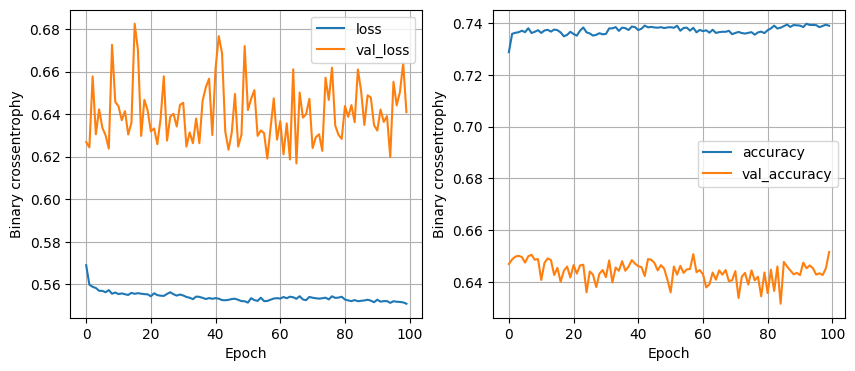

1072/1072 [==============================] - 4s 4ms/step - loss: 0.5663 - accuracy: 0.7277
16 nodes, dropout 0, lr 0.01, batch size 64, epochs=epochs
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                496       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 785
Trainable params: 

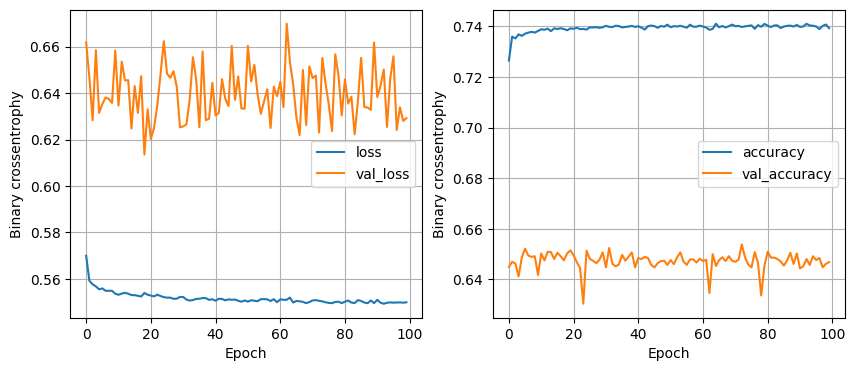

1072/1072 [==============================] - 2s 2ms/step - loss: 0.5591 - accuracy: 0.7286


TypeError: ignored

In [59]:
# set up and run model predictions
epochs = 100

# view the loss and accuracy of model
least_val_loss = float('inf')
least_loss_model = None

for node in [16, 32, 64]:
  for dropout_probability in [0, 0.2]:
    for learning_rate in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f'{node} nodes, dropout {dropout_probability}, lr {learning_rate}, batch size {batch_size}, epochs={epochs}')
        nn, history = train_model(X_train, y_train, node, dropout_probability, learning_rate, batch_size, epochs)
        plot_history(history)
        val_loss = nn.evaluate(X_valid, y_valid)
        val_loss = sum(val_loss)
        if sum(val_loss) < least_val_loss:
          least_val_loss = sum(val_loss)
          least_loss_model = nn

In [60]:
val_loss

[0.5590556263923645, 0.7285926938056946]

In [55]:
history = nn.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, verbose=0)

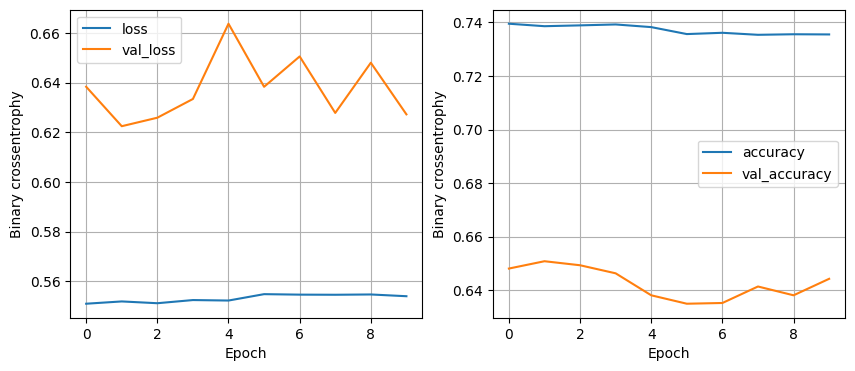

In [56]:
plot_history(history)

In [57]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y-pred > 0.5).astype(int).reshape(-1,)

print(classification_report(y_test, y_pred))

AttributeError: ignored

In [ ]:
# Evaluate the model using the test data
# model_loss, model_accuracy = nn.evaluate(X_test, y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# # Evaluate the model using the test data
# model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
# original run
# 268/268 - 0s - loss: 0.5545 - accuracy: 0.7272 - 351ms/epoch - 1ms/step
# Loss: 0.5544604063034058, Accuracy: 0.7272303104400635

In [ ]:
# Export our model to HDF5 file
# fit_model.save("model_1st_good_run_.h5")
# keras.callbacks.ModelCheckpoint() # to save the best model